# Frechet random forests for Symmetric Positive Definite matrices (SPD)

In [1]:
import sys, os; sys.path.append(os.path.dirname(os.getcwd())) 

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.cm import get_cmap

# from ipywidgets import *

from typing import Union

import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.linalg import expm
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import wishart
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV
# from sklearn import neighbors, clone


from pyfrechet.metric_spaces import MetricData, Euclidean, LogCholesky, spd_to_log_chol, log_chol_to_spd
# from pyfrechet.regression.frechet_regression import LocalFrechet, GlobalFrechet
# from pyfrechet.regression.kernels import NadarayaWatson, gaussian, epanechnikov
# from pyfrechet.regression.knn import KNearestNeighbours
from pyfrechet.regression.bagged_regressor import BaggedRegressor
from pyfrechet.regression.trees import Tree
from pyfrechet.metrics import mse

INFO: Using numpy backend


## Simulation from R. Yu paper:

In [2]:
def sim_matrix_normal_one(M: np.ndarray, var: float,
                      random_state: Union[None, int]=None) -> np.ndarray:
    """
    Sample one observation from a symmetric matrix variate normal distribution with mean
    matrix M and variance parameter var. See:

    REFERENCE:
    Qi Zhang, Lingzhou Xue, and Bing Li. Dimension reduction for Fréchet regression. Journal of the
    American Statistical Association, pages 1-15, 2023.
    """
    d=M.shape[0]
    np.random.seed(random_state)
    Z=np.zeros(shape=(d,d))
    Z[np.diag_indices(d)]=np.random.normal(size=d, loc=0, scale=1)
    Z[np.tril_indices(d, k=-1)]=np.random.normal(size=np.tril_indices(d, k=-1)[0].size, loc=0, scale=0.5)
    Z[np.triu_indices(d, k=1)]=Z[np.tril_indices(d, k=-1)]
    A=M+np.sqrt(var)*Z
    return A

def sim_matrix_normal(M: np.ndarray, var: float,
                      size: int=1,
                      random_state: Union[None, int]=None) -> list:
    """
    Returns (a list) a sample of the size specified from a symmetric matrix variate normal distribution
    with mean matrix M and variance parameter var.
    (See sim_matrix_normal_one() function for details)
    """
    d=M.shape[0]
    np.random.seed(random_state)
    sample=[]

    for n in range(size):
        sample.append(sim_matrix_normal_one(M, var))
    return sample

In [117]:
# Some checkings
M=np.array([[1,2,3],
            [2,5,4],
            [3,4,0]])

sim_matrix_normal(M, 1, size=3, random_state=100)

[array([[1.73183679, 1.64352189, 3.1050673 ],
        [1.64352189, 3.81393386, 3.89406265],
        [3.1050673 , 3.89406265, 1.50385249]]),
 array([[0.59656439, 1.66517604, 3.34273242],
        [1.66517604, 5.17889745, 3.38975502],
        [3.34273242, 3.38975502, 0.03211604]]),
 array([[-0.28297526,  2.18016443,  2.8083158 ],
        [ 2.18016443,  5.71535414,  3.70793655],
        [ 2.8083158 ,  3.70793655, -0.17300143]])]

### Scenario 1

In [4]:
def rho(X: np.ndarray, beta: np.ndarray) -> float:
    return np.cos(4*np.pi*np.dot(X, beta))

def DX(X: np.ndarray, beta: np.ndarray) -> np.ndarray:
    """
    Return the matrix D(X) for predictor values X and parameter vector beta
    as in simulation of [1].

    REFERENCE:
    [1] Random Forest Weighted Local Frechet Regression (R. Yu)
    """
    return np.array([[1, rho(X, beta)],
                     [rho(X, beta), 1]])


In [5]:
beta2=np.array([0.75, 0.25])
beta5=np.array([0.1, 0.2, 0.3, 0.4, 0])
beta10=np.array([0.1, 0.2, 0.3, 0.4, 0, 0, 0, 0, 0, 0])
beta20=np.zeros(shape=20); beta20[[0,1,2,3]]=[0.1, 0.2, 0.3, 0.4]; beta20[[-4, -3, -2, -1]]=[0.1, 0.2, 0.3, 0.4]; beta20=beta20/2

In [6]:
def sim_DX(beta: np.ndarray, size: int) -> tuple[list, list]:
    """
    Function to sample predictors (X_1,...,X_p) following U([0,1]^p) with p=beta.size and its
    corresponding D(X) matrix (using DX() function above).
    It returns a tuple of two lists, one for the sample of predictors and other for the sample
    of matrices D(X).

    beta is the vector of parameters for the simulation and must be provided
    size is the number of samples to draw

    REFERENCE:
    [1] Random Forest Weighted Local Frechet Regression (R. Yu)
    """
    sampleX=[]
    sample=[]
    for n in range(size):
        X=np.random.uniform(size=beta.size)
        sampleX.append(X)
        sample.append(DX(X, beta))

    return (sampleX, sample)

In [7]:
sim_DX(beta2, size=3)

([array([0.32023914, 0.20923495]),
  array([0.59273498, 0.91800076]),
  array([0.42063656, 0.66853464])],
 [array([[ 1.        , -0.86081821],
         [-0.86081821,  1.        ]]),
  array([[ 1.        , -0.57810013],
         [-0.57810013,  1.        ]]),
  array([[1.        , 0.97622032],
         [0.97622032, 1.        ]])])

#### $p=2$

In [8]:
sample_DX=sim_DX(beta2, size=100)
sample_logY=[]
for k in range(len(sample_DX[1])):
    sample_logY.append(sim_matrix_normal_one(M=sample_DX[1][k], var=0.2, random_state=100))

sample_logY

[array([[ 0.21748109, -0.74109491],
        [-0.74109491,  1.15325134]]),
 array([[0.21748109, 0.65872727],
        [0.65872727, 1.15325134]]),
 array([[0.21748109, 0.52939598],
        [0.52939598, 1.15325134]]),
 array([[ 0.21748109, -0.24414167],
        [-0.24414167,  1.15325134]]),
 array([[0.21748109, 0.49321896],
        [0.49321896, 1.15325134]]),
 array([[0.21748109, 0.91151499],
        [0.91151499, 1.15325134]]),
 array([[0.21748109, 1.22830721],
        [1.22830721, 1.15325134]]),
 array([[ 0.21748109, -0.70601296],
        [-0.70601296,  1.15325134]]),
 array([[0.21748109, 1.14717868],
        [1.14717868, 1.15325134]]),
 array([[0.21748109, 1.07347492],
        [1.07347492, 1.15325134]]),
 array([[0.21748109, 1.02000371],
        [1.02000371, 1.15325134]]),
 array([[ 0.21748109, -0.4253272 ],
        [-0.4253272 ,  1.15325134]]),
 array([[0.21748109, 0.52315058],
        [0.52315058, 1.15325134]]),
 array([[ 0.21748109, -0.40925363],
        [-0.40925363,  1.15325134]]),


In [9]:
sampleY=[expm(A) for A in sample_logY]
sampleY

[array([[ 1.74469924, -1.66635047],
        [-1.66635047,  3.84877681]]),
 array([[1.63539826, 1.4541953 ],
        [1.4541953 , 3.70118901]]),
 array([[1.49303833, 1.14019774],
        [1.14019774, 3.50847321]]),
 array([[ 1.29511204, -0.50730462],
        [-0.50730462,  3.23955917]]),
 array([[1.45932263, 1.0559505 ],
        [1.0559505 , 3.46274736]]),
 array([[2.02079454, 2.1424236 ],
        [2.1424236 , 4.22022765]]),
 array([[2.74028249, 3.20264012],
        [3.20264012, 5.18017317]]),
 array([[ 1.69630927, -1.57470967],
        [-1.57470967,  3.78347556]]),
 array([[2.52763248, 2.90533946],
        [2.90533946, 4.89755992]]),
 array([[2.35214308, 2.65167131],
        [2.65167131, 4.66365968]]),
 array([[2.23477885, 2.47661655],
        [2.47661655, 4.50687262]]),
 array([[ 1.40297545, -0.90144172],
        [-0.90144172,  3.38625405]]),
 array([[1.48703173, 1.12555173],
        [1.12555173, 3.50032935]]),
 array([[ 1.39093404, -0.86548705],
        [-0.86548705,  3.36989519]]),


In [14]:
X=np.c_[sample_DX[0]]
sampleY_LogChol=np.c_[[spd_to_log_chol(A) for A in sampleY]]
M=LogCholesky(dim=2)
y=MetricData(M, sampleY_LogChol)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

scaler=MinMaxScaler(feature_range=(0,1))
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [35]:
base = Tree(split_type='2means',
            impurity_method='cart',
            mtry=2,
            min_split_size=1)
forest = BaggedRegressor(estimator=base,
                         n_estimators=100,
                         bootstrap_fraction=1,
                         bootstrap_replace=True,
                         n_jobs=4)
forest.fit(X_train, y_train)

BaggedRegressor(bootstrap_fraction=1, bootstrap_replace=True,
                estimator=Tree(min_split_size=1, mtry=2, split_type='2means'),
                n_jobs=4)

In [36]:
forest_predictions = forest.predict(X_test)
print(f'MSE: {mse(y_test, forest_predictions)}')

forest_fitted = forest.predict(X_train)
print(f'MSE: {mse(y_train, forest_fitted)}')

MSE: 0.5012228203660477
MSE: 0.3811726952030371


In [38]:
oob_errors=forest.oob_errors()

In [39]:
oob_errors

array([0.97658441, 0.98253475, 0.35478908, 0.42465132, 1.45957036,
       0.08072506, 0.47497636, 0.28151771, 0.76898019, 1.24909715,
       0.25443525, 0.91420518, 0.65508139, 0.28543696, 0.15704558,
       0.36566721, 0.31040367, 0.60475167, 0.29457168, 0.9925497 ,
       0.19034523, 0.50480358, 0.26014582, 0.17175448, 0.70297711,
       0.6798265 , 0.71310292, 0.40056673, 1.22513131, 0.34468514,
       0.43703333, 0.79059136, 1.3491647 , 1.17271482, 0.09462101,
       0.13856072, 0.11891418, 0.37516161, 0.56174851, 0.17899845,
       0.90194243, 0.57002473, 0.43857891, 0.1558132 , 0.18355958,
       0.45466577, 0.61140488, 0.87585081, 0.1463001 , 0.63578921,
       0.15456385, 0.53990254, 0.49710963, 0.98615919, 0.21087513,
       0.3452672 , 1.09690701, 0.37383664, 0.49210176, 0.37107439,
       1.01240415, 0.09367142, 0.88716337, 1.10169801, 0.6338472 ,
       0.58853856, 0.2627232 , 0.40262248, 0.62440952, 0.53869843,
       0.75251176, 0.31879664, 1.32243982, 0.41792424, 0.52929

In [40]:
alpha=0.05
Dalpha=np.percentile(oob_errors, (1-alpha)*100)
np.mean(y_train.M.d(forest_predictions.data, y_test.data) <= Dalpha)

0.96

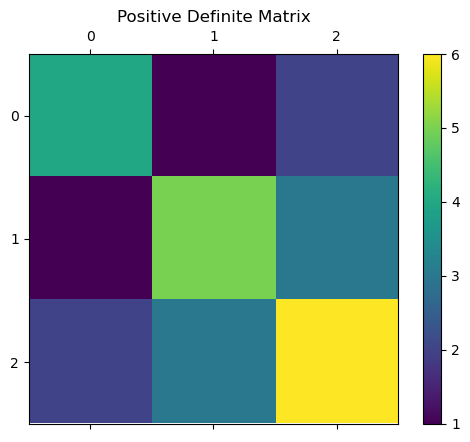

In [118]:
# IDEA FROM CHATGPT
def visualize_positive_definite_matrix(matrix):
    fig, ax = plt.subplots()
    cax = ax.matshow(matrix, cmap='viridis')

    # Add colorbar
    fig.colorbar(cax)

    plt.title('Positive Definite Matrix')
    plt.show()

# Example: visualize a 3x3 positive definite matrix
matrix = np.array([[4, 1, 2],
                   [1, 5, 3],
                   [2, 3, 6]])

visualize_positive_definite_matrix(matrix)

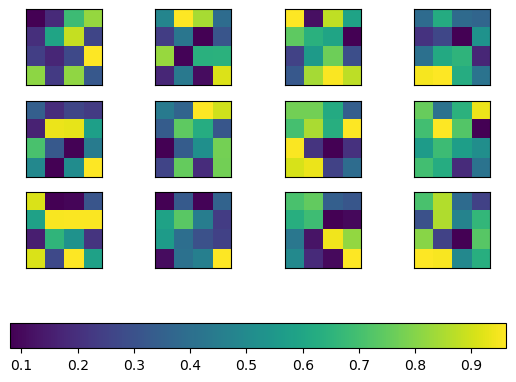

In [15]:
def visualize_positive_definite_matrices(matrices, layout: Union[tuple, None]=None):
    """
    layout=(num_rows, num_cols)
    """
    if not layout:
        num_cols = int(np.ceil(np.sqrt(num_matrices)))
        num_rows = int(np.ceil(num_matrices / num_cols))
    else:
        num_rows=layout[0]
        num_cols=layout[1]

    fig, axs = plt.subplots(num_rows, num_cols)

    # Loop through the matrices and plot them
    for i, matrix in enumerate(matrices):
        row = i // num_cols
        col = i % num_cols
        ax = axs[row, col]
        cax = ax.matshow(matrix, cmap='viridis')
        # ax.set_title(f'Matrix {i+1}')

        ax.set_xticks([])
        ax.set_yticks([])

    # Create a single colorbar for all matrices
    fig.colorbar(cax, ax=axs.ravel().tolist(), location='bottom')
    plt.show()

# Example: visualize multiple 3x3 positive definite matrices
matrix_size = 4
num_matrices = 12
matrices = [np.random.rand(matrix_size, matrix_size) for _ in range(num_matrices)]
visualize_positive_definite_matrices(matrices)

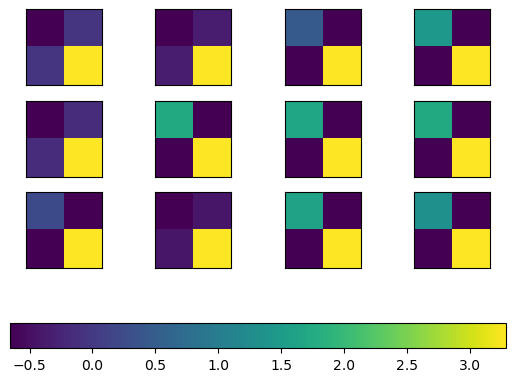

In [50]:
# fig, ax = plt.subplots(1,2)
# ax[0].matshow(log_chol_to_spd(y_test.data[15]), cmap='viridis')
# ax[1].matshow(log_chol_to_spd(forest_predictions.data[15]), cmap='viridis')

# # Add colorbar
# # fig.colorbar(cax)
# plt.show()

matrices_to_plot=[]
index_to_plot=range(12)
for i in index_to_plot:
    matrices_to_plot.append(log_chol_to_spd(y_test.data[i]))
visualize_positive_definite_matrices(matrices=matrices_to_plot)

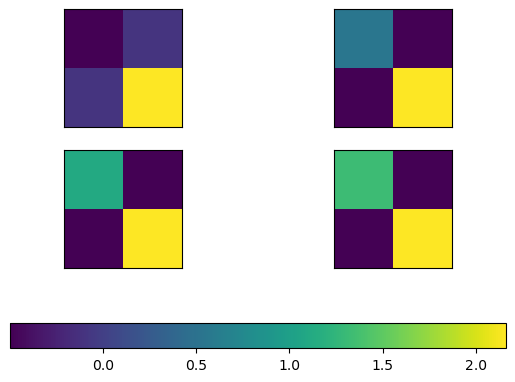

In [43]:
matrices_to_plot=[]
index_to_plot=[0,5]
for i in index_to_plot:
    matrices_to_plot.append(log_chol_to_spd(y_test.data[i]))
    matrices_to_plot.append(log_chol_to_spd(forest_predictions.data[i]))
visualize_positive_definite_matrices(matrices=matrices_to_plot, layout=(len(index_to_plot),2))

In [32]:
Dalpha

7.529495971530416

In [15]:
M=LogCholesky(2)
M.d(sampleY[0], sampleY[1])

4.521712579987448

In [20]:
M=LogCholesky(4)
A=spd_to_log_chol(sampleY[0])
B=spd_to_log_chol(sampleY[1])
M.d(A, B)

2.4340564518486407

array([ 0.23825258,  0.44711363, -1.10543785])

In [ ]:
np.linalg.norm()

#### $p=10$

In [11]:
sample_DX=sim_DX(beta10, size=250)
sample_logY=[]
for k in range(len(sample_DX[1])):
    sample_logY.append(sim_matrix_normal_one(M=sample_DX[1][k], var=0.2**2, random_state=100))

sampleY=[expm(A) for A in sample_logY]

X=np.c_[sample_DX[0]]
sampleY_LogChol=np.c_[[spd_to_log_chol(A) for A in sampleY]]
M=LogCholesky(dim=10)
y=MetricData(M, sampleY_LogChol)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

scaler=MinMaxScaler(feature_range=(0,1))
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [12]:
base = Tree(split_type='2means',
            impurity_method='cart',
            mtry=3, # Take sqrt(predictor variables)
            min_split_size=1)
forest = BaggedRegressor(estimator=base,
                         n_estimators=100,
                         bootstrap_fraction=1,
                         bootstrap_replace=True,
                         n_jobs=4)
forest.fit(X_train, y_train)

BaggedRegressor(bootstrap_fraction=1, bootstrap_replace=True,
                estimator=Tree(min_split_size=1, mtry=3, split_type='2means'),
                n_jobs=4)

In [43]:
forest_predictions = forest.predict(X_test)
print(f'MSE: {mse(y_test, forest_predictions)}')

forest_fitted = forest.predict(X_train)
print(f'MSE: {mse(y_train, forest_fitted)}')

oob_errors=forest.oob_errors()

alpha=0.05
Dalpha=np.percentile(oob_errors, (1-alpha)*100)
np.mean(y_train.M.d(forest_predictions.data, y_test.data) <= Dalpha)

MSE: 1.4591901872751496
MSE: 0.5520137635651695


0.9206349206349206

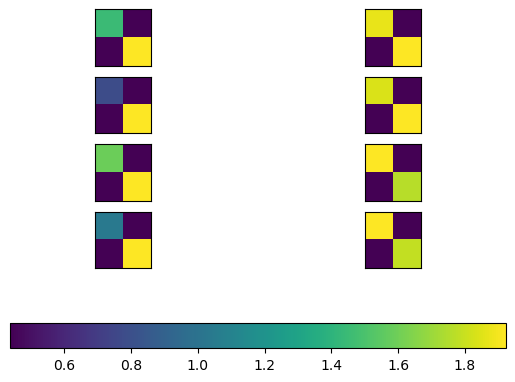

In [16]:
matrices_to_plot=[]
for i in [0,10,20,24]:
    matrices_to_plot.append(log_chol_to_spd(y_test.data[i]))
    matrices_to_plot.append(log_chol_to_spd(forest_predictions.data[i]))
visualize_positive_definite_matrices(matrices=matrices_to_plot, layout=(4,2))

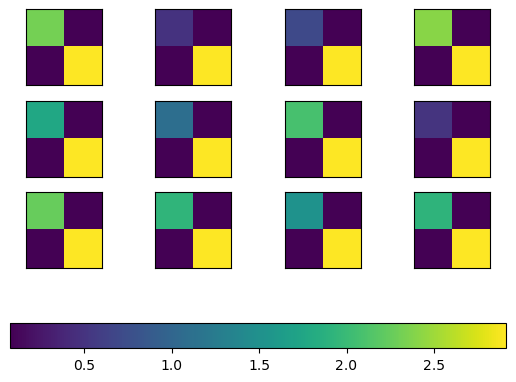

In [17]:
visualize_positive_definite_matrices(sampleY[2:14])

### Scenario 2

In [33]:
def rho1(X: np.ndarray, beta1: np.ndarray) -> float:
    return 0.8*np.cos(4*np.pi*np.dot(X, beta1))

def rho2(X: np.ndarray, bata2: np.ndarray) -> float:
    return 0.4*np.cos(4*np.pi*np.dot(X, beta2))

def DX(X: np.ndarray, beta1: np.ndarray, beta2: np.ndarray) -> np.ndarray:
    return np.array([[1, rho1(X, beta1), rho2(X, beta2)],
                     [rho1(X, beta1), 1, rho1(X, beta1)],
                     [rho2(X, beta2), rho1(X, beta1), 1]])

def sim_DX(beta1: np.ndarray, beta2: np.ndarray, size: int) -> tuple[list, list]:
    """
    Function to sample predictors (X_1,...,X_p) following U([0,1]^p) with p=beta.size and its
    corresponding D(X) matrix (using DX() function above).
    It returns a tuple of two lists, one for the sample of predictors and other for the sample
    of matrices D(X).

    beta is the vector of parameters for the simulation and must be provided
    size is the number of samples to draw

    REFERENCE:
    [1] Random Forest Weighted Local Frechet Regression (R. Yu)
    """
    sampleX=[]
    sample=[]
    for n in range(size):
        X=np.random.uniform(size=beta.size)
        sampleX.append(X)
        sample.append(DX(X, beta1, beta2))

    return (sampleX, sample)

In [34]:
beta1_2=np.array([0.75, 0.25]); beta2_2=np.array([0.75, 0.25])
beta1_5=np.array([0.1, 0.2, 0.3, 0.4, 0]); beta2_5=np.array([0, 0.1, 0.2, 0.3, 0.4])
beta1_10=np.array([0.1, 0.2, 0.3, 0.4, 0, 0, 0, 0, 0, 0]); beta2_10=np.array([0, 0, 0, 0, 0, 0, 0.1, 0.2, 0.3, 0.4])
beta1_20=np.zeros(shape=20); beta1_20[[0,1,2,3]]=[0.1, 0.2, 0.3, 0.4]
beta2_20=np.zeros(shape=20); beta2_20[[-4,-3,-2,-1]]=[0.1, 0.2, 0.3, 0.4]


#### $p=10$

In [ ]:
sample_DX=sim_DX(beta1_10, beta2_10, size=250)
sample_logY=[]
for k in range(len(sample_DX[1])):
    sample_logY.append(sim_matrix_normal_one(M=sample_DX[1][k], var=0.2**2, random_state=100))

sampleY=[expm(A) for A in sample_logY]

X=np.c_[sample_DX[0]]
sampleY_LogChol=np.c_[[spd_to_log_chol(A) for A in sampleY]]
M=LogCholesky(dim=10)
y=MetricData(M, sampleY_LogChol)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

scaler=MinMaxScaler(feature_range=(0,1))
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [ ]:
base = Tree(split_type='2means',
            impurity_method='cart',
            mtry=3, # Take sqrt(predictor variables)
            min_split_size=1)
forest = BaggedRegressor(estimator=base,
                         n_estimators=100,
                         bootstrap_fraction=1,
                         bootstrap_replace=True,
                         n_jobs=4)
forest.fit(X_train, y_train)

In [ ]:
forest_predictions = forest.predict(X_test)
print(f'MSE: {mse(y_test, forest_predictions)}')

forest_fitted = forest.predict(X_train)
print(f'MSE: {mse(y_train, forest_fitted)}')

oob_errors=forest.oob_errors()

alpha=0.05
Dalpha=np.percentile(oob_errors, (1-alpha)*100)
np.mean(y_train.M.d(forest_predictions.data, y_test.data) <= Dalpha)

In [ ]:
matrices_to_plot=[]
for i in [0,10,20,24]:
    matrices_to_plot.append(log_chol_to_spd(y_test.data[i]))
    matrices_to_plot.append(log_chol_to_spd(forest_predictions.data[i]))
visualize_positive_definite_matrices(matrices=matrices_to_plot, layout=(4,2))

In [ ]:
visualize_positive_definite_matrices(sampleY[2:14])

#### $p=20$

In [ ]:
sample_DX=sim_DX(beta1_20, beta2_20, size=250)
sample_logY=[]
for k in range(len(sample_DX[1])):
    sample_logY.append(sim_matrix_normal_one(M=sample_DX[1][k], var=0.2**2, random_state=100))

sampleY=[expm(A) for A in sample_logY]

X=np.c_[sample_DX[0]]
sampleY_LogChol=np.c_[[spd_to_log_chol(A) for A in sampleY]]
M=LogCholesky(dim=10)
y=MetricData(M, sampleY_LogChol)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

scaler=MinMaxScaler(feature_range=(0,1))
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [ ]:
base = Tree(split_type='2means',
            impurity_method='cart',
            mtry=4, # Take sqrt(predictor variables)
            min_split_size=1)
forest = BaggedRegressor(estimator=base,
                         n_estimators=100,
                         bootstrap_fraction=1,
                         bootstrap_replace=True,
                         n_jobs=4)
forest.fit(X_train, y_train)

In [ ]:
forest_predictions = forest.predict(X_test)
print(f'MSE: {mse(y_test, forest_predictions)}')

forest_fitted = forest.predict(X_train)
print(f'MSE: {mse(y_train, forest_fitted)}')

oob_errors=forest.oob_errors()

alpha=0.05
Dalpha=np.percentile(oob_errors, (1-alpha)*100)
np.mean(y_train.M.d(forest_predictions.data, y_test.data) <= Dalpha)

In [ ]:
matrices_to_plot=[]
for i in [0,10,20,24]:
    matrices_to_plot.append(log_chol_to_spd(y_test.data[i]))
    matrices_to_plot.append(log_chol_to_spd(forest_predictions.data[i]))
visualize_positive_definite_matrices(matrices=matrices_to_plot, layout=(4,2))

In [ ]:
visualize_positive_definite_matrices(sampleY[2:14])

## Simulation for Wishart matrices

### Simulation 1

In [2]:
# Test wishart matrices
V=np.array([[1, 0.7],
            [0.7, 1]])
w=wishart(df=3, scale=V)
print(w.rvs(size=3, random_state=42).shape)
sample_list=[A for A in w.rvs(size=3, random_state=42)[:]]
sample_list

(3, 2, 2)


[array([[7.41214745, 6.15425083],
        [6.15425083, 8.68345727]]),
 array([[2.98953082, 1.92194675],
        [1.92194675, 3.05776317]]),
 array([[5.26782209, 4.74908998],
        [4.74908998, 4.52489975]])]

In [3]:
def scale_matrix(t):
    return np.array([[1, 0.7*2*(t-0.5)],
                     [0.7*2*(t-0.5), 1]])

scale_matrix(0.5)

array([[1., 0.],
       [0., 1.]])

In [4]:
def sim_regression_matrices(size: int=1,
                            random_state: int=42,
                            df: int=2):
    np.random.seed(random_state)
    sample_t=np.sort(np.random.uniform(size=size))
    true_t=np.linspace(start=0, stop=1, num=size)
    sample_V=[wishart(df=df, scale=scale_matrix(sample_t[k])).rvs(size=1) for k in range(sample_t.size)]
    true_Vt=[df*scale_matrix(true_t[k]) for k in range(true_t.size)] # Expectation of Wishart is degree_freedom * scale_matrix

    return {'sample': (sample_t, sample_V),
            'true': (true_t, true_Vt)}

sample=sim_regression_matrices(size=100, random_state=111)

In [8]:
print(sample['sample'][0])
print(sample['true'][1])

[0.01644282 0.02247832 0.02744796 0.03338316 0.03407709 0.03818193
 0.05277604 0.05308965 0.06934179 0.07395756 0.08119266 0.10532609
 0.11836775 0.12796081 0.13499553 0.13804205 0.14781138 0.14916296
 0.14961322 0.16906975 0.17527984 0.17745066 0.17862581 0.17934478
 0.17948485 0.20368352 0.21049925 0.22642109 0.23772645 0.23868214
 0.2742273  0.27425353 0.2953253  0.29727251 0.31884013 0.3189664
 0.32281393 0.33765619 0.36150419 0.36473134 0.40054555 0.40502704
 0.41697908 0.42022449 0.42131788 0.43605902 0.44126818 0.45413664
 0.46165662 0.46622141 0.46900855 0.4720635  0.48127804 0.48208878
 0.4850363  0.49792484 0.54390891 0.5652854  0.57727383 0.59249847
 0.59522545 0.61217018 0.61541569 0.61834027 0.62124292 0.65568231
 0.66881406 0.66960024 0.67384806 0.68301313 0.68465799 0.69772773
 0.7278491  0.73441308 0.76824793 0.76926247 0.79396256 0.80206458
 0.80659105 0.81376692 0.81384438 0.81520746 0.81722006 0.84056965
 0.84179162 0.86468549 0.87250164 0.90077418 0.90681313 0.91870

In [9]:
X=np.c_[sample['sample'][0]]
sampleY_LogChol=np.c_[[spd_to_log_chol(A) for A in sample['sample'][1]]]
M=LogCholesky(dim=2)
y=MetricData(M, sampleY_LogChol)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)
scaler=MinMaxScaler(feature_range=(0,1))
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [10]:
base = Tree(split_type='2means',
            impurity_method='cart',
            mtry=None, # It is a regression curve setting, only one predictor
            min_split_size=1)
forest = BaggedRegressor(estimator=base,
                         n_estimators=100,
                         bootstrap_fraction=1,
                         bootstrap_replace=True,
                         n_jobs=4)
forest.fit(X_train, y_train)

BaggedRegressor(bootstrap_fraction=1, bootstrap_replace=True,
                estimator=Tree(min_split_size=1, split_type='2means'),
                n_jobs=4)

In [11]:
forest_predictions = forest.predict(X_test)
print(f'MSE: {mse(y_test, forest_predictions)}')

forest_fitted = forest.predict(X_train)
print(f'MSE: {mse(y_train, forest_fitted)}')

oob_errors=forest.oob_errors()

alpha=0.05
Dalpha=np.percentile(oob_errors, (1-alpha)*100)
np.mean(y_train.M.d(forest_predictions.data, y_test.data) <= Dalpha)

MSE: 3.2651768777304895
MSE: 2.07129835417954


0.92

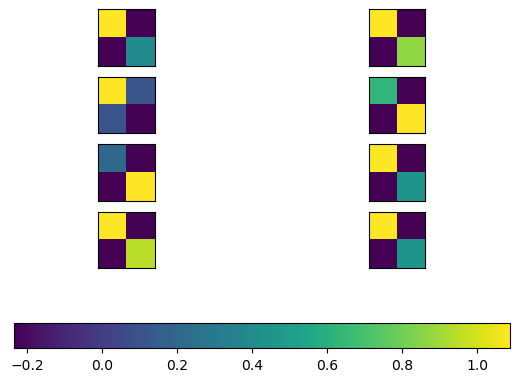

In [13]:
def visualize_positive_definite_matrices(matrices, layout: Union[tuple, None]=None,
                                         cmap='viridis'):
    """
    layout=(num_rows, num_cols)
    """
    if not layout:
        num_cols = int(np.ceil(np.sqrt(num_matrices)))
        num_rows = int(np.ceil(num_matrices / num_cols))
    else:
        num_rows=layout[0]
        num_cols=layout[1]

    fig, axs = plt.subplots(num_rows, num_cols)

    # Loop through the matrices and plot them
    for i, matrix in enumerate(matrices):
        row = i // num_cols
        col = i % num_cols
        ax = axs[row, col]
        cax = ax.matshow(matrix, cmap=cmap)
        # ax.set_title(f'Matrix {i+1}')

        ax.set_xticks([])
        ax.set_yticks([])

    # Create a single colorbar for all matrices
    fig.colorbar(cax, ax=axs.ravel().tolist(), location='bottom')
    plt.show()

matrices_to_plot=[]
for i in [0,10,20,24]:
    matrices_to_plot.append(log_chol_to_spd(y_test.data[i]))
    matrices_to_plot.append(log_chol_to_spd(forest_predictions.data[i]))
visualize_positive_definite_matrices(matrices=matrices_to_plot, layout=(4,2))

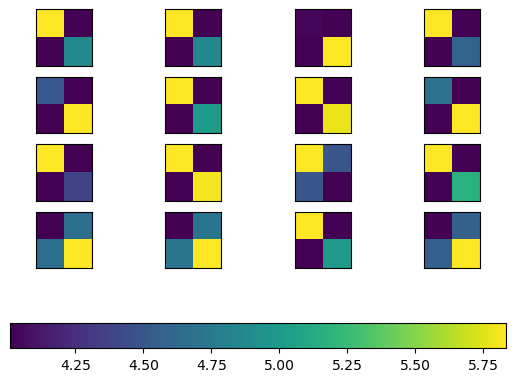

In [14]:
matrices_to_plot=[log_chol_to_spd(A) for A in y_test.data][0:16]
visualize_positive_definite_matrices(matrices_to_plot, layout=(4,4), cmap='viridis')

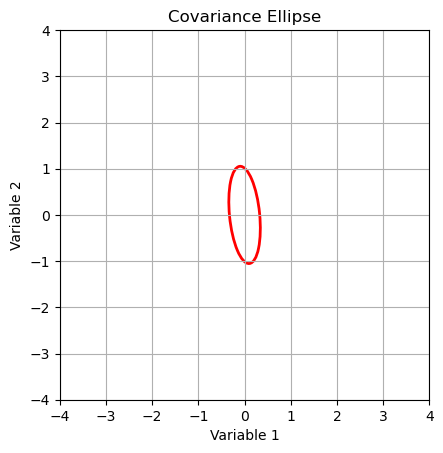

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Example covariance matrix
# cov_matrix = np.array([[1.0, 0.5],
#                        [0.5, 2.0]])
cov_matrix=sample['sample'][1][0]

# Compute eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Compute the angle of rotation from the eigenvectors
theta = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

# Create figure and axis
fig, ax = plt.subplots()

# Plot the covariance ellipse
ellipse = Ellipse(xy=(0, 0),
                  width=np.sqrt(eigenvalues[0]),
                  height=np.sqrt(eigenvalues[1]),
                  angle=theta,
                  edgecolor='red',
                  fc='None',
                  lw=2)
ax.add_patch(ellipse)

# Set aspect of plot to equal to make circles look like circles
ax.set_aspect('equal', 'box')

# Set labels and title
plt.xlabel('Variable 1')
plt.ylabel('Variable 2')
plt.title('Covariance Ellipse')

# Set limits based on eigenvalues for better visualization
# lim = 2* np.sqrt(eigenvalues)  # 95% confidence interval (Chi-squared distribution with df=2)
# plt.xlim(-lim[0], lim[0])
# plt.ylim(-lim[1], lim[1])
plt.xlim(-4,4)
plt.ylim(-4,4)

plt.grid(True)
plt.show()


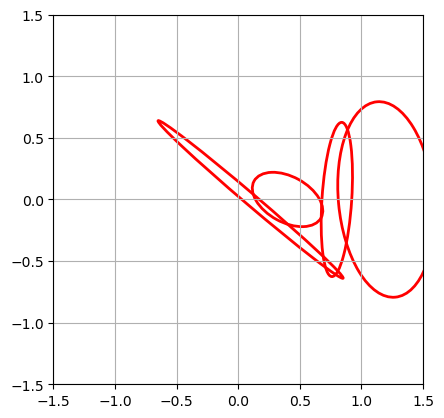

In [18]:
def plot_ellipse(mat: np.ndarray, ax, 
                 xy: tuple=(0,0),
                 scale_factor=1,
                 edgecolor='red',
                 facecolor='None',
                 linewidth=2,
                 alpha=1):
    eigenvalues, eigenvectors = np.linalg.eig(mat)
    theta = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    ellipse = Ellipse(xy=xy,
                  width=scale_factor*np.sqrt(eigenvalues[0]),
                  height=scale_factor*np.sqrt(eigenvalues[1]),
                  angle=theta,
                  edgecolor=edgecolor,
                  facecolor=facecolor,
                  lw=linewidth,
                  alpha=alpha)
    ax.add_patch(ellipse)

fig, ax=plt.subplots()
for i in [1,4,8,12]:
    plot_ellipse(sample['sample'][1][i], ax=ax, xy=(i/10,0))
ax.set_aspect('equal', 'box')
lim=1.5
plt.xlim(-lim,lim)
plt.ylim(-lim,lim)
plt.grid(True)
plt.show()

C:\Users\J2404\AppData\Local\Temp\ipykernel_27160\4144876936.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette=get_cmap('hsv')


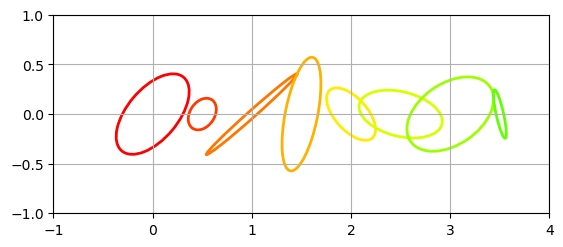

In [24]:
from matplotlib.cm import get_cmap

fig, ax=plt.subplots()
color_palette=get_cmap('hsv')
for i in range(0, y_train.data.shape[0], 10):
    plot_ellipse(log_chol_to_spd(y_train.data[i]), ax=ax, xy=(i/20,0), scale_factor=1/2,
                 edgecolor=color_palette(i))
ax.set_aspect('equal', 'box')
xlim=4
ylim=1
plt.xlim(-1,xlim)
plt.ylim(-ylim,ylim)
plt.grid(True)
plt.show()

C:\Users\J2404\AppData\Local\Temp\ipykernel_27160\195229727.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette=get_cmap('hsv')


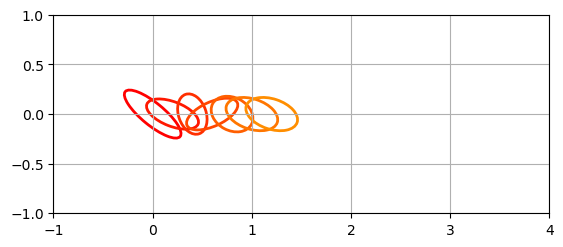

In [35]:
fig, ax=plt.subplots()
color_palette=get_cmap('hsv')
# colors=[color_palette(color) for color in np.linspace(0,1,num=len(range(0, forest_predictions.data.shape[0], 4)))]
for i in range(0, forest_predictions.data.shape[0], 4):
    plot_ellipse(log_chol_to_spd(forest_predictions.data[i]), ax=ax, xy=(i/20,0), scale_factor=1/2,
                 edgecolor=color_palette(i))
ax.set_aspect('equal', 'box')
xlim=4
ylim=1
plt.xlim(-1,xlim)
plt.ylim(-ylim,ylim)
plt.grid(True)
plt.show()

### Simulation 2 (preferred)

In [2]:
def w_1(t):
    if t<=0.5:
        return np.cos(np.pi*t)**2
    else:
        return 0
    
def w_3(t):
    if t>=0.5:
        return np.cos(np.pi*(1-t))**2
    else:
        return 0


In [5]:
Sigma_1=np.array([[1, -0.6],
                  [-0.6, 0.5]])
Sigma_2=np.array([[1, 0],
                  [0, 1]])
Sigma_3=np.array([[0.5, 0.4],
                  [0.4, 1]])

def Sigma_true(t: float, 
           Sigmas: tuple):
    return w_1(t)*Sigmas[0]+(1-w_1(t)-w_3(t))*Sigmas[1]+w_3(t)*Sigmas[2]

In [101]:
np.linalg.eig(Sigma_3)

(array([0.27830094, 1.22169906]),
 array([[-0.87464248, -0.48476853],
        [ 0.48476853, -0.87464248]]))

In [6]:
def sim_regression_matrices(Sigmas: tuple,
                            size: int=1,
                            random_state: Union[None, int]=None,
                            df: int=2):
    np.random.seed(random_state)
    sample_t=np.sort(np.random.uniform(size=size))
    true_t=np.linspace(start=0, stop=1, num=size)
    sample_Y=[(1/df)*wishart(df=df, scale=Sigma_true(sample_t[k], Sigmas)).rvs(size=1) for k in range(sample_t.size)]
    true_Sigmat=[Sigma_true(true_t[k], Sigmas) for k in range(true_t.size)] 

    return {'sample': (sample_t, sample_Y),
            'true': (true_t, true_Sigmat)}

In [7]:
sample=sim_regression_matrices((Sigma_1, Sigma_2, Sigma_3), size=200, random_state=444, df=2)

In [ ]:
sample['sample'][1]

In [8]:
X=np.c_[sample['sample'][0]]
sampleY_LogChol=np.c_[[spd_to_log_chol(A) for A in sample['sample'][1]]]
M=LogCholesky(dim=2)
y=MetricData(M, sampleY_LogChol)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)
scaler=MinMaxScaler(feature_range=(0,1))
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [9]:
base = Tree(split_type='2means',
            impurity_method='cart',
            mtry=None, # It is a regression curve setting, only one predictor
            min_split_size=1)
forest = BaggedRegressor(estimator=base,
                         n_estimators=100,
                         bootstrap_fraction=1,
                         bootstrap_replace=True,
                         n_jobs=4)
forest.fit(X_train, y_train)

BaggedRegressor(bootstrap_fraction=1, bootstrap_replace=True,
                estimator=Tree(min_split_size=1, split_type='2means'),
                n_jobs=4)

In [10]:
forest_predictions = forest.predict(X_test)
print(f'MSE: {mse(y_test, forest_predictions)}')

forest_fitted = forest.predict(X_train)
print(f'MSE: {mse(y_train, forest_fitted)}')

oob_errors=forest.oob_errors()

alpha=0.05
Dalpha=np.percentile(oob_errors, (1-alpha)*100)
np.mean(y_train.M.d(forest_predictions.data, y_test.data) <= Dalpha)

MSE: 1.867054344349796
MSE: 1.6930962908960707


0.98

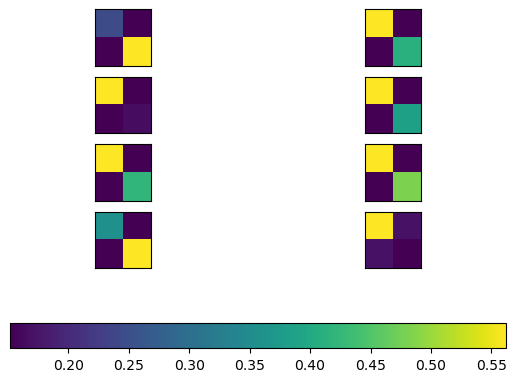

In [10]:
def visualize_positive_definite_matrices(matrices, layout: Union[tuple, None]=None,
                                         cmap='viridis'):
    """
    layout=(num_rows, num_cols)
    """
    if not layout:
        num_cols = int(np.ceil(np.sqrt(num_matrices)))
        num_rows = int(np.ceil(num_matrices / num_cols))
    else:
        num_rows=layout[0]
        num_cols=layout[1]

    fig, axs = plt.subplots(num_rows, num_cols)

    # Loop through the matrices and plot them
    for i, matrix in enumerate(matrices):
        row = i // num_cols
        col = i % num_cols
        ax = axs[row, col]
        cax = ax.matshow(matrix, cmap=cmap)
        # ax.set_title(f'Matrix {i+1}')

        ax.set_xticks([])
        ax.set_yticks([])

    # Create a single colorbar for all matrices
    fig.colorbar(cax, ax=axs.ravel().tolist(), location='bottom')
    plt.show()

matrices_to_plot=[]
for i in [1,8,15,21]:
    matrices_to_plot.append(log_chol_to_spd(y_test.data[i]))
    matrices_to_plot.append(log_chol_to_spd(forest_predictions.data[i]))
visualize_positive_definite_matrices(matrices=matrices_to_plot, layout=(4,2))

C:\Users\J2404\AppData\Local\Temp\ipykernel_6544\3179214916.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette=get_cmap('hsv')


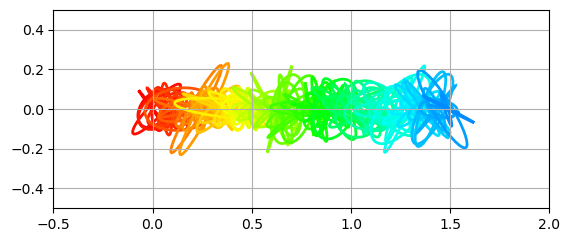

In [11]:
def plot_ellipse(mat: np.ndarray, ax, 
                 xy: tuple=(0,0),
                 scale_factor=1,
                 edgecolor='red',
                 facecolor='None',
                 linewidth=2,
                 alpha=1):
    eigenvalues, eigenvectors = np.linalg.eig(mat)
    theta = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    ellipse = Ellipse(xy=xy,
                  width=scale_factor*np.sqrt(eigenvalues[0]),
                  height=scale_factor*np.sqrt(eigenvalues[1]),
                  angle=theta,
                  edgecolor=edgecolor,
                  facecolor=facecolor,
                  lw=linewidth,
                  alpha=alpha)
    ax.add_patch(ellipse)

fig, ax=plt.subplots()
color_palette=get_cmap('hsv')
for i in range(0, y_train.data.shape[0]):
    plot_ellipse(log_chol_to_spd(y_train.data[i]), ax=ax, xy=(i/100,0), scale_factor=1/5,
                 edgecolor=color_palette(i))
ax.set_aspect('equal', 'box')
xlim=2
ylim=1
plt.xlim(-0.5,2)
plt.ylim(-0.5,0.5)
plt.grid(True)
plt.show()

C:\Users\J2404\AppData\Local\Temp\ipykernel_19916\2259392834.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette=get_cmap('hsv')


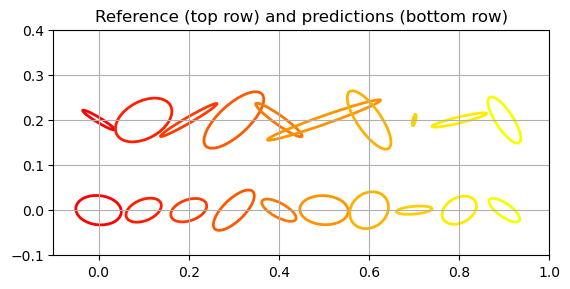

In [17]:
fig, ax=plt.subplots()
color_palette=get_cmap('hsv')
# colors=[color_palette(color) for color in np.linspace(0,1,num=len(range(0, forest_predictions.data.shape[0], 4)))]
for i in range(0, forest_predictions.data.shape[0],5):
    plot_ellipse(log_chol_to_spd(forest_predictions.data[i]), ax=ax, xy=(i/50,0), scale_factor=1/10,
                 edgecolor=color_palette(i))
    plot_ellipse(log_chol_to_spd(y_test.data[i]), ax=ax, xy=(i/50,0.2), scale_factor=1/10,
                 edgecolor=color_palette(i))
ax.set_aspect('equal', 'box')
xlim=2
ylim=0.5
plt.xlim(-0.1,1)
plt.ylim(-0.1,0.4)
plt.grid(True)
plt.title('Reference (top row) and predictions (bottom row)')
plt.show()

In [12]:
t_grid=sample['true'][0]
predicted_curve=[log_chol_to_spd(forest.predict(np.array([[sample['true'][0][k]]])).data) for k  in range(sample['true'][0].size)]


C:\Users\J2404\AppData\Local\Temp\ipykernel_6544\2153981264.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette=get_cmap('hsv')


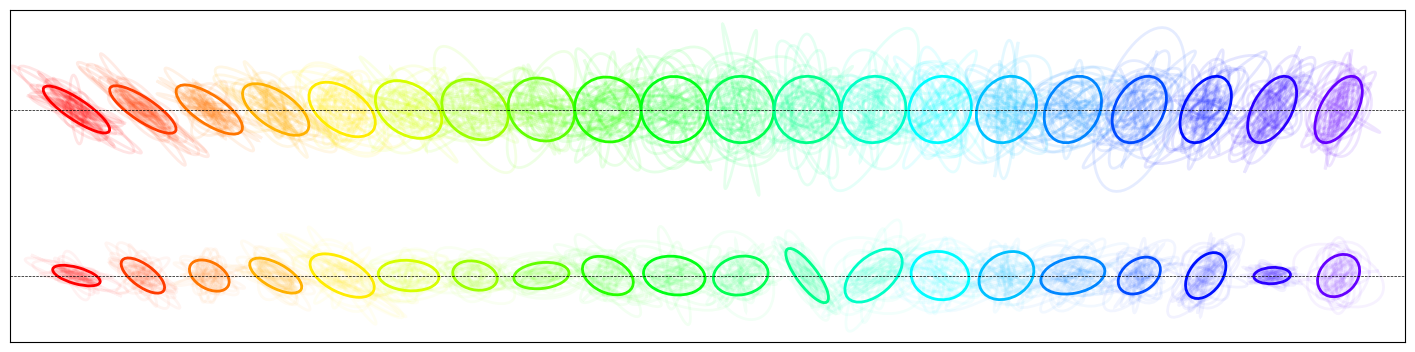

In [22]:
df=2 # Degrees of freedom of the original Wishar distribution

fig, ax=plt.subplots(figsize=(18,8))
color_palette=get_cmap('hsv')
indices_to_plot=list(range(0, len(predicted_curve), 10))
# indices_to_plot.append(len(predicted_curve)-1)
for i in indices_to_plot:
    plot_ellipse(predicted_curve[i], ax=ax, xy=(i/50,0), scale_factor=1/5,
                 edgecolor=color_palette(i))
    plot_ellipse(sample['true'][1][i], ax=ax, xy=(i/50,0.5), scale_factor=1/5,
                 edgecolor=color_palette(i))
    for k in range(30):
        plot_ellipse((1/df)*wishart(df=df, scale=Sigma_true(sample['true'][0][i], Sigmas=(Sigma_1, Sigma_2, Sigma_3))).rvs(size=1), 
                     ax=ax, xy=(i/50,0.5), scale_factor=1/5, edgecolor=color_palette(i), alpha=0.1)
        plot_ellipse((1/df)*wishart(df=df, scale=predicted_curve[i]).rvs(size=1), 
                     ax=ax, xy=(i/50,0), scale_factor=1/5, edgecolor=color_palette(i), alpha=0.05)
    # plot_ellipse((1/df)*sample['true'][1][i], ax=ax, xy=(i/50,0.2), scale_factor=1/10,
    #              edgecolor=color_palette(i))
ax.set_aspect('equal', 'box')
xlim=2
ylim=0.5
plt.xlim(-0.2,4.0)
plt.ylim(-0.2,0.8)
plt.grid(True)
# plt.title('True curve (top row) and predicted (bottom row)')
plt.xticks([])
plt.yticks([])
plt.axhline(y=0, linestyle='dashed', color='black', linewidth=0.5)
plt.axhline(y=0.5, linestyle='dashed', color='black', linewidth=0.5)
plt.show()

In [31]:
print(len(predicted_curves[0]))
len(list(range(5, len(predicted_curve)+5, 10)))

200


20

In [13]:
def plot_OOB_balls_SPD2(predictions: np.ndarray,
                        indices_to_plot: list[int],
                        Dalpha: float,
                        ax,
                        reference: Union[np.ndarray, None]=None,
                        scale_factor: float=1/10,
                        xy_factor: float=50,
                        df: int=2,
                        MC_samples: int=100,
                        edge_color='deepskyblue',
                        alpha=0.1) -> None:

    
    if not reference is None:
        for index_to_plot in indices_to_plot:

            sample=wishart(df=df, scale=(1/df)*log_chol_to_spd(predictions[index_to_plot])).rvs(size=MC_samples)
            sample=[spd_to_log_chol(A) for A  in sample]
            for A in sample:
                if M.d(A, predictions[index_to_plot])<=Dalpha:
                    plot_ellipse(log_chol_to_spd(A), ax=ax, xy=(index_to_plot/xy_factor,0), scale_factor=scale_factor, edgecolor=edge_color,
                                alpha=alpha)

            plot_ellipse(log_chol_to_spd(predictions[index_to_plot]), ax=ax, 
                        xy=(index_to_plot/xy_factor,0),scale_factor=scale_factor, edgecolor='black', alpha=1)

            plot_ellipse(log_chol_to_spd(reference[index_to_plot]), ax=ax, 
                        xy=(index_to_plot/xy_factor,0),scale_factor=scale_factor, edgecolor='red', alpha=1)

    else:
        for index_to_plot in indices_to_plot:

            sample=wishart(df=df, scale=(1/df)*log_chol_to_spd(predictions[index_to_plot])).rvs(size=MC_samples)
            sample=[spd_to_log_chol(A) for A  in sample]
            for A in sample:
                if M.d(A, predictions[index_to_plot])<=Dalpha:
                    plot_ellipse(log_chol_to_spd(A), ax=ax, xy=(index_to_plot/xy_factor,0), scale_factor=scale_factor, edgecolor=edge_color,
                                alpha=alpha)

            plot_ellipse(log_chol_to_spd(predictions[index_to_plot]), ax=ax, 
                        xy=(index_to_plot/xy_factor,0),scale_factor=scale_factor, edgecolor='black', alpha=1)
                

0.96
True


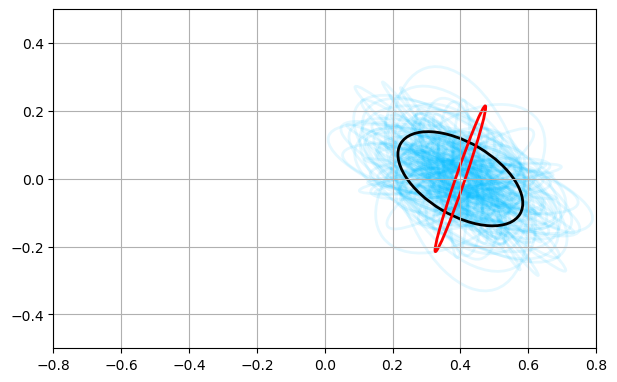

In [41]:
M=LogCholesky(dim=2)
alpha=0.05
Dalpha=np.percentile(oob_errors, (1-alpha)*100)
print(np.mean(y_train.M.d(forest_predictions.data, y_test.data) <= Dalpha))
print(M.d(forest_predictions.data[20], y_test.data[20]) <= Dalpha)

fig, ax=plt.subplots(figsize=(7, 7))
plot_OOB_balls_SPD2(forest_predictions, reference=y_test.data, indices_to_plot=[20],
                    Dalpha=Dalpha, ax=ax, scale_factor=1/2, MC_samples=150, xy_factor=50, alpha=0.1)
ax.set_aspect('equal', 'box')
xlim=2
ylim=0.5
plt.xlim(-0.8,0.8)
plt.ylim(-0.5,0.5)
plt.grid(True)
# plt.title('OOB Prediction Ball')
# plt.xticks([])
# plt.yticks([])
plt.show()

0.96
False
False


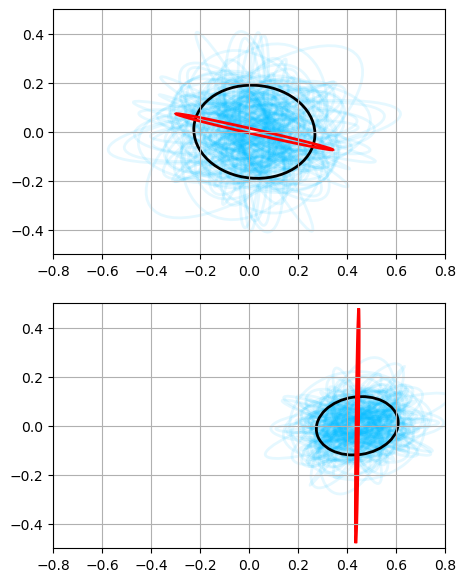

In [115]:
M=LogCholesky(dim=2)
alpha=0.05
Dalpha=np.percentile(oob_errors, (1-alpha)*100)
print(np.mean(y_train.M.d(forest_predictions.data, y_test.data) <= Dalpha))
print(M.d(forest_predictions.data[1], y_test.data[1]) <= Dalpha)
print(M.d(forest_predictions.data[22], y_test.data[22]) <= Dalpha)

fig, ax=plt.subplots(2,1, figsize=(14, 7))
plot_OOB_balls_SPD2(forest_predictions, reference=y_test.data, indices_to_plot=[1],
                    Dalpha=Dalpha, ax=ax[0], scale_factor=1/2, MC_samples=150, xy_factor=50, alpha=0.1)
ax[0].set_aspect('equal', 'box')
ax[0].set_xlim(-0.8,0.8)
ax[0].set_ylim(-0.5,0.5)
ax[0].grid(True)

plot_OOB_balls_SPD2(forest_predictions, reference=y_test.data, indices_to_plot=[22],
                    Dalpha=Dalpha, ax=ax[1], scale_factor=1/2, MC_samples=150, xy_factor=50, alpha=0.1)
ax[1].set_aspect('equal', 'box')
ax[1].set_xlim(-0.8,0.8)
ax[1].set_ylim(-0.5,0.5)
ax[1].grid(True)
# plt.title('OOB Prediction Ball')
# plt.xticks([])
# plt.yticks([])
plt.show()

In [114]:
np.where(y_train.M.d(forest_predictions.data, y_test.data) > Dalpha)

(array([ 1, 22], dtype=int64),)

#### Plot with several random forest predictions

In [14]:
predicted_curves=[]

for simul in tqdm(range(10), desc='Iteration'):
    sample=sim_regression_matrices((Sigma_1, Sigma_2, Sigma_3), size=200, df=2)
    X=np.c_[sample['sample'][0]]
    sampleY_LogChol=np.c_[[spd_to_log_chol(A) for A in sample['sample'][1]]]
    M=LogCholesky(dim=2)
    y=MetricData(M, sampleY_LogChol)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    scaler=MinMaxScaler(feature_range=(0,1))
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)

    base = Tree(split_type='2means',
            impurity_method='medoid',
            mtry=None, # It is a regression curve setting, only one predictor
            min_split_size=1)
    forest = BaggedRegressor(estimator=base,
                            n_estimators=100,
                            bootstrap_fraction=1,
                            bootstrap_replace=True,
                            n_jobs=4)
    forest.fit(X_train, y_train)

    t_grid=sample['true'][0]
    predicted_curve=[log_chol_to_spd(forest.predict(np.array([[sample['true'][0][k]]])).data) for k  in range(sample['true'][0].size)]

    predicted_curves.append(predicted_curve)
    

Iteration: 100%|██████████| 10/10 [04:04<00:00, 24.43s/it]


C:\Users\J2404\AppData\Local\Temp\ipykernel_6544\2767030789.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette=get_cmap('hsv')


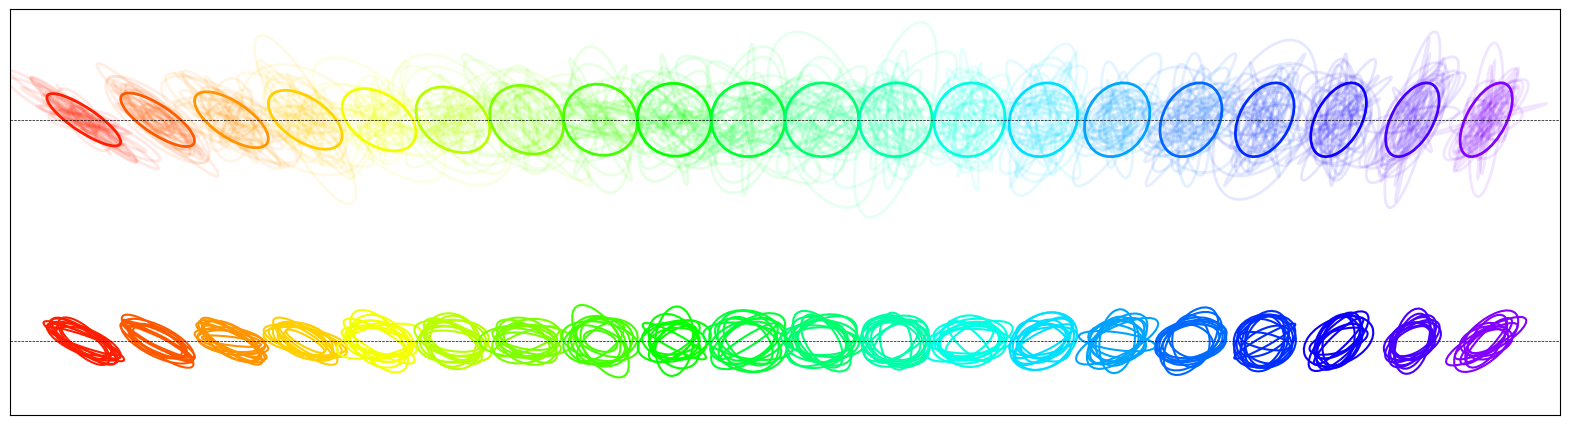

In [38]:
df=2 # Degrees of freedom of the original Wishar distribution

fig, ax=plt.subplots(figsize=(20,10))
color_palette=get_cmap('hsv')
indices_to_plot=list(range(5, len(predicted_curve)+5, 10))
# indices_to_plot.append(len(predicted_curve)-1)
for i in indices_to_plot:
    for simul in range(len(predicted_curves)):
        plot_ellipse(predicted_curves[simul][i], ax=ax, xy=((i-5)/50,0), scale_factor=1/5,
                    edgecolor=color_palette(i), alpha=1, linewidth=1.5)
    plot_ellipse(sample['true'][1][i], ax=ax, xy=((i-5)/50,0.6), scale_factor=1/5,
                 edgecolor=color_palette(i))
    for k in range(30):
        plot_ellipse((1/df)*wishart(df=df, scale=Sigma_true(sample['true'][0][i], Sigmas=(Sigma_1, Sigma_2, Sigma_3))).rvs(size=1), 
                     ax=ax, xy=((i-5)/50,0.6), scale_factor=1/5, edgecolor=color_palette(i), alpha=0.1)
    # plot_ellipse((1/df)*sample['true'][1][i], ax=ax, xy=(i/50,0.2), scale_factor=1/10,
    #              edgecolor=color_palette(i))
ax.set_aspect('equal', 'box')
xlim=2
ylim=0.5
plt.xlim(-0.2,4.0)
plt.ylim(-0.2,0.9)
plt.grid(True)
# plt.title('True curve (top row) and predicted (bottom row)')
plt.xticks([])
plt.yticks([])
plt.axhline(y=0, linestyle='dashed', color='black', linewidth=0.5)
plt.axhline(y=0.6, linestyle='dashed', color='black', linewidth=0.5)
plt.show()